In [ ]:
!pip install shap pyDOE2
from IPython.core.display import display, HTML
import regex as re
import lightgbm
import pandas as pd
import shap
import sklearn

import xgboost as xgb
from sklearn.model_selection import train_test_split
import lightgbm as lgb


shap.initjs()

Patch to match style consistency

In [ ]:
import numpy as np
from matplotlib import lines
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

plt.rcParams['figure.dpi'] = 300
import shap.plots._force_matplotlib

# PATCH draw_base_element
def patch_draw_base_element(base_value, ax):
    x, y = np.array([[base_value, base_value], [0.13, 0.25]])
    line = lines.Line2D(x, y, lw=2., color='#F2F2F2')
    line.set_clip_on(False)
    ax.add_line(line)

    font0 = FontProperties()
    font = font0.copy()
    font.set_weight('bold')

    text_out_val = plt.text(base_value, 0.25, f'{base_value:.2f}',
                            fontproperties=font,
                            fontsize=14,
                            horizontalalignment='center')
    text_out_val.set_bbox(dict(facecolor='white', edgecolor='white'))

    text_out_val = plt.text(base_value, 0.33, 'base value',
                            fontsize=12, alpha=0.5,
                            horizontalalignment='center')
    text_out_val.set_bbox(dict(facecolor='white', edgecolor='white'))
shap.plots._force_matplotlib.draw_base_element = patch_draw_base_element
# ENDPATCH draw_base_element
# PATCH update_axis_limits
def patch_update_axis_limits(ax, total_pos, pos_features, total_neg,
                       neg_features, base_value, out_value):

    print("patched")
    ax.set_ylim(-0.5, 0.15)
    pos_padding = np.max([np.abs(total_pos) * 1.5,
                      np.abs(total_neg) * 1.5])  #0.8 # 0.6 #1.1
    neg_padding = np.max([np.abs(total_pos) * 0.8,
                      np.abs(total_neg) * 0.8])
    padding = np.max([np.abs(total_pos) * 0.8,
                      np.abs(total_neg) * 0.8])


    print(f"pos {pos_padding}, neg {neg_padding}")

    if len(pos_features) > 0:
        min_x = min(np.min(pos_features[:, 0].astype(float)), base_value) - neg_padding
    else:
        min_x = out_value - padding
    if len(neg_features) > 0:
        max_x = max(np.max(neg_features[:, 0].astype(float)), base_value) + pos_padding
    else:
        max_x = out_value + padding



    ax.set_xlim(-0.04, 0.35)

    plt.tick_params(top=True, bottom=False, left=False, right=False, labelleft=False,
                    labeltop=True, labelbottom=False)
    plt.locator_params(axis='x', nbins=12)

    for key, spine in zip(plt.gca().spines.keys(), plt.gca().spines.values()):
        if key != 'top':
            spine.set_visible(False)
shap.plots._force_matplotlib.update_axis_limits = patch_update_axis_limits
# ENDPATCH update_axis_limits



Set up tutorial examples

Start by training the "should you bring an umbrella?" model

In [ ]:
preX = pd.read_csv("Umbrella.csv")
preX = preX.sample(frac=1)
X_display = preX.iloc[:,:-1]
y_display = preX.iloc[:,-1]

PRECIPITATION = {
    "none": 0,
    "drizzle": 1,
    "rain": 2,
    "snow": 3,
    "sleet": 4,
    "hail": 5
}

y = y_display
X = X_display
X = X.replace({"Precipitation":PRECIPITATION})

X_train = X.iloc[:300]
y_train = y.iloc[:300]

X_test = X.iloc[300:]
y_test = y.iloc[300:]

d_train = lightgbm.Dataset(X_train, label=y_train)
d_test = lightgbm.Dataset(X_test, label=y_test)

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "keep_training_booster": True
}

#model = lgb.train(params, d_train, 10000, valid_sets=[d_test]) #early_stopping_rounds=50, verbose_eval=1000
model = lightgbm.LGBMClassifier(max_bin= 512,
    learning_rate= 0.05,
    boosting_type= "gbdt",
    objective= "binary",
    metric= "binary_logloss",
    num_leaves= 10,
    verbose= -1,
    min_data= 100,
    boost_from_average= True)
model.fit(X_train, y_train)

<ipython-input-17-59731d8556ad>:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({"Precipitation":PRECIPITATION})


LGBMClassifier(boost_from_average=True, learning_rate=0.05, max_bin=512,
               metric='binary_logloss', min_data=100, num_leaves=10,
               objective='binary', verbose=-1)

Find the location of one of the two tutorial examples

In [ ]:
print(X.loc[(X['Precipitation'] == 5) & (X['Temperature'] == 23) & (X['Wind(mph)'] == 10)])
print(X.loc[(X['Precipitation'] == 0) & (X['Temperature'] == 70) & (X['Wind(mph)'] == 30)])
theloc = X.index.get_loc(330)

     Precipitation  Temperature  Wind(mph)
330              5           23         10
    Precipitation  Temperature  Wind(mph)
96              0           70         30


Generate a tutorial explanation

patched
pos 0.11999999999999994, neg 0.06399999999999997


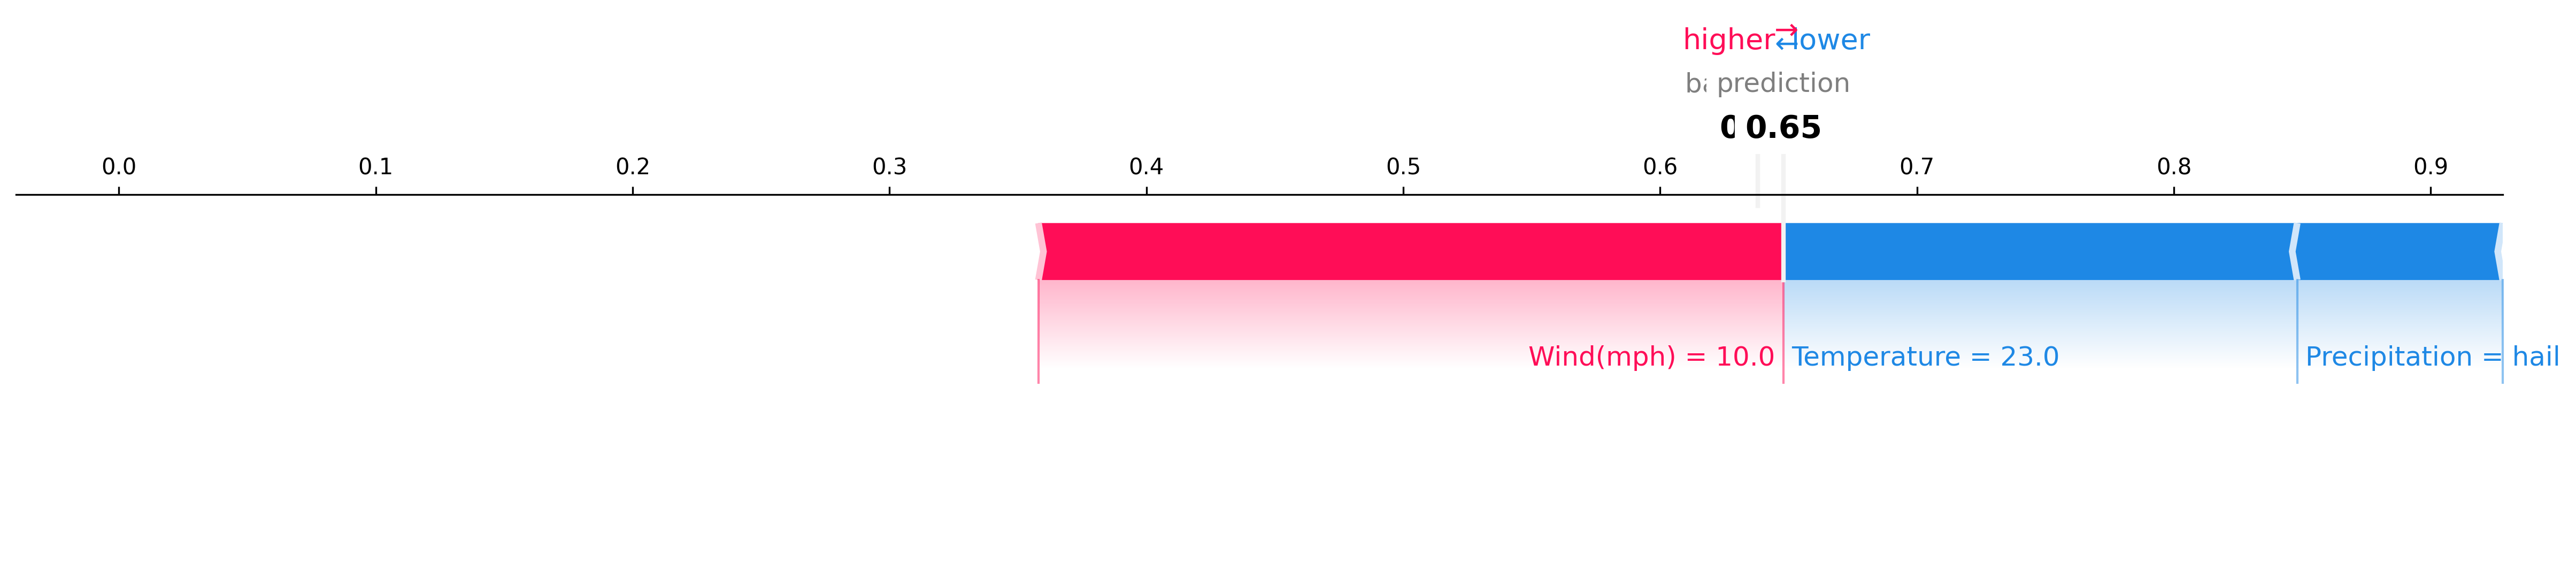

In [ ]:
explainer = shap.Explainer(model, X, model_output="probability")
#shap_values = explainer(X)
shap.plots.force(0.638, shap_values = np.array([-0.08, -0.2, 0.29]), features = X_display.iloc[theloc,:], out_names="prediction", contribution_threshold=0.000001, matplotlib=True, figsize=(20,3), show=True)

#Loan Instances

Edit and prepare dataset

In [ ]:
# load dataset
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

EDUCATION_NUM = {
    16.0: "Doctorate",
    15.0: "Prof. School",
    14.0: "Masters",
    13.0: "Bachelors",
    12.0: "Some College",
    11.0: "Associate", #Assoc-acdm
    10.0: "Vocational", #Assoc-voc
    9.0: "HS grad",
    8.0: "12th",
    7.0: "11th",
    6.0: "10th",
    5.0: "9th",
    4.0: "7th-8th",
    3.0: "5th-6th",
    2.0: "1st-4th",
    1.0: "Preschool"
}

OCCUPATION_NUM = {
    "Tech-support": "Tech Support",
    "Craft-repair": "Craft/Repair",
    "Other-service": "Other Service",
    "Sales": "Sales",
    "Exec-managerial": "Exec. Managerial",
    "Prof-specialty": "Prof. Specialty",
    "Handlers-cleaners": "Handler/Cleaner",
    "Machine-op-inspct": "Machine Op. Inspector",
    "Adm-clerical": "Admin. Clerical",
    "Farming-fishing": "Farming/Fishing",
    "Transport-moving": "Transport/Moving",
    "Priv-house-serv": "Private House Service",
    "Protective-serv": "Protective Service",
    "Armed-Forces": "Armed Forces"

}
X_display = X_display.replace({"Education-Num":EDUCATION_NUM})
X_display = X_display.replace({"Occupation":OCCUPATION_NUM})
X = X.rename(columns={"Education-Num": "Education"})
X_display = X_display.rename(columns={"Education-Num": "Education"})#, "Hours per week": "Hours worked per week"})

X = X.drop(['Capital Loss', 'Capital Gain', 'Race', 'Relationship', 'Country', 'Workclass', 'Marital Status'], axis=1)
X_display = X_display.drop(['Capital Loss', 'Capital Gain', 'Race', 'Relationship', 'Country', 'Workclass', 'Marital Status'], axis=1)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

Train the model

In [ ]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    'objective':'multi:softprob',
    "boost_from_average": True
}

params_xgb={
    'base_score':0.5,
    'learning_rate':0.05,
    'max_depth':5,
    'min_child_weight':100,
    'n_estimators':200,
    'num_class': 2,
    'nthread':-1,
    'objective':'multi:softprob',
    'seed':2018,
    'eval_metric':'auc'
}

model = lgb.LGBMClassifier(max_bin= 512,
    learning_rate= 0.05,
    boosting_type= "gbdt",
    objective= "binary",
    metric= "binary_logloss",
    num_leaves= 10,
    verbose= -1,
    min_data= 100,
    boost_from_average= True)
model.fit(X_train, y_train)

LGBMClassifier(boost_from_average=True, learning_rate=0.05, max_bin=512,
               metric='binary_logloss', min_data=100, num_leaves=10,
               objective='binary', verbose=-1)

Our 7 loan application instances

In [ ]:
#val = 610 # Woman Side-by-side
#val = 11116 # Man Side-by-side
#val = 32353 # Man 3
#val = 217 # Man 2
#val = 15040 # Man 1
#val = 32429 # Woman 3
val = 32556 # Woman 2
#val = 91#91 # Woman 1

theloc = val

Generate SHAP Explanation

In [ ]:
explainer = shap.Explainer(model, X, model_output="probability")
shap_values = explainer(X)

 99%|===================| 32293/32561 [01:44<00:00]       

patched
pos 0.15704999999999994, neg 0.08375999999999997


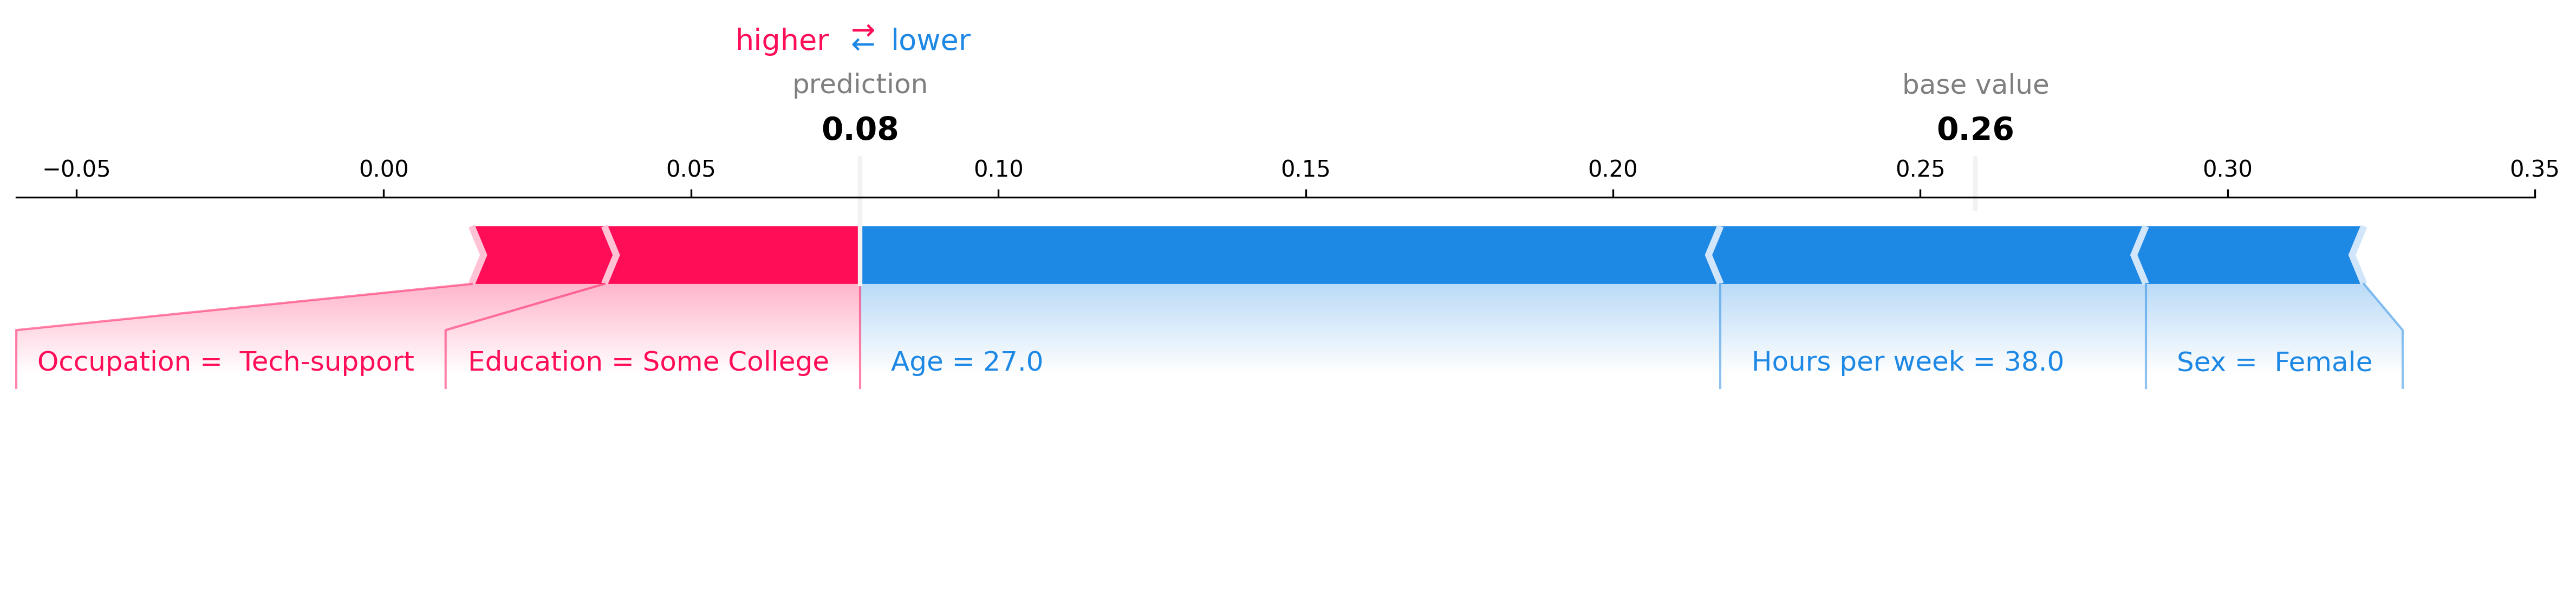

In [ ]:
#shap_values_standin0 = pd.Series({'Age': 0.0307, 'Education': -0.0287, 'Occupation': -0.0026, 'Sex': -0.1075, 'Hours per week': -0.0351}) # Woman 1
shap_values_standin0 = pd.Series({'Age': -0.14, 'Education': 0.0416, 'Occupation':  0.0216, 'Sex': -0.0355, 'Hours per week':  -0.0692}) # Woman 2
#shap_values_standin0 = pd.Series({'Age': 0.1209, 'Education': 0.3008, 'Occupation': 0.0317, 'Sex': -0.0766, 'Hours per week':  0.0115}) # Woman 3
#shap_values_standin0 = pd.Series({'Age': -0.2119, 'Education': 0.0011, 'Occupation': 0.0171,'Sex': 0.0096, 'Hours per week':  -0.0149}) # Man 1
#shap_values_standin0 = pd.Series({'Age': 0.0565, 'Education': 0.1427, 'Occupation': 0.0507, 'Sex': 0.0854, 'Hours per week':  0.0756}) # Man 2
#shap_values_standin0 = pd.Series({'Age': -0.0012, 'Education': -0.189, 'Occupation': 0.0022, 'Sex': 0.0448, 'Hours per week':  0.0256}) # Man 3
#shap_values_standin0 = pd.Series({'Age': 0.0774, 'Education': 0.1962, 'Occupation': 0.0318, 'Sex': 0.106, 'Hours per week':  0.0741}) # Man Fair
#shap_values_standin0 = pd.Series({'Age': 0.0668, 'Education': 0.1619, 'Occupation': 0.0297,'Sex': -0.1366, 'Hours per week':  0.0318}) # Woman Fair

shap.plots.force(0.259, shap_values = np.array(shap_values_standin0), features = X_display.iloc[theloc,:], out_names="prediction", contribution_threshold=0.000001, matplotlib=True, figsize=(20,3), show=True)
